In [1]:
% matplotlib inline

import sys
import gc
import time as systime

import numpy as np

from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
from scipy.special import gammaln
from scipy.stats import chisquare, chi2

from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import h5py
import pywt

import readligo as rl

plt.rcParams['agg.path.chunksize'] = 10000

In [2]:
# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs)/dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

In [3]:
t0 = systime.time()
fs = 4096 # sampling rate

# get segment list
start = 931035615
stop = 931640415 # 932245215
fl = rl.FileList()
segList = rl.getsegs(start, stop, 'L1', flag='DATA', filelist=fl)

Using data directory . ...
WARNING!  No file found for GPS 931033088 and IFO L1
WARNING! No file found with GPS start time 931033088
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 931037184 and IFO L1
WARNING! No file found with GPS start time 931037184
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 931041280 and IFO L1
WARNING! No file found with GPS start time 931041280
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 931045376 and IFO L1
WARNING! No file found with GPS start time 931045376
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 931049472 and IFO L1
WARNING! No file found with GPS start time 931049472
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 931053568 and IFO L1
WARNING! No file found with GPS start time 931053568
Segment list may contain errors due to missing files.
WARNING!  No 

Loading ./cache/L1/L-L1_LOSC_4_V1-931069952-4096.hdf5


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:174: RuntimeWarning: divide by zero encountered in log


Loading ./cache/L1/L-L1_LOSC_4_V1-931069952-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931069952-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931074048-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931074048-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931074048-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931074048-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931074048-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931074048-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931074048-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931074048-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931074048-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931074048-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931074048-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931074048-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931074048-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931074048-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931074048-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931074048-4096.hdf5
Loading ./cache/L1/L-L1_LOSC

Loading ./cache/L1/L-L1_LOSC_4_V1-931434496-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931434496-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931438592-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931442688-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931446784-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931450880-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931454976-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931459072-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931463168-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931467264-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931471360-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931475456-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931479552-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931483648-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931495936-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931500032-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931504128-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-931508224-4096.hdf5
Loading ./cache/L1/L-L1_LOSC

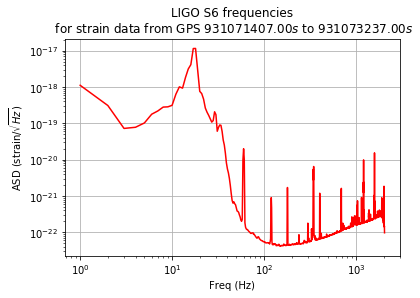

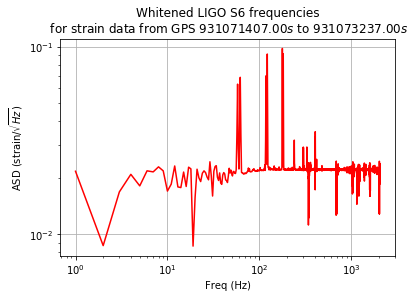

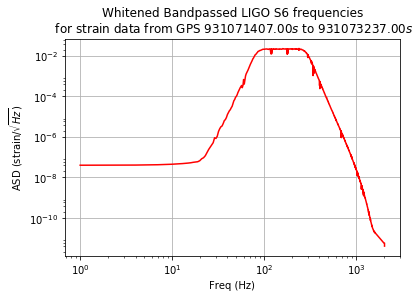

In [4]:
# loop over good segments
#fn_H1 = 'cache/H-H1_LOSC_4_V2-1126257414-4096.hdf5' #'cache/H-H1_LOSC_4_V2-1126259446-32.hdf5'
# 'H-H1_LOSC_4_V2-1126257414-4096.hdf5'
#strain, time, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
#begin = time[0]
#end = time[-1]
#ts = time[1]-time[0]

f = open('L1_times.csv', 'w')
#np.savetxt(f, ['# begin end del_t c_t c_s c_E signif seg_begin seg_eng cbc burst stoch'], fmt='%s')
f.close()

ex_plot = True
clean_plot = False

global n_cbc
global n_burst
global n_stoch

n_cbc = 0
n_burst = 0
n_stoch = 0

for (begin, end) in segList: # for q in [0]:
    gc.collect()
    strain, meta, dq = rl.getstrain(begin, end, 'L1', filelist=fl)
    ts = meta['dt']
    time = np.arange(begin, end, ts)
    
    # first whiten strain data
    NFFT = 1*fs    
    Pxx, freqs = mlab.psd(strain, Fs=fs, NFFT=NFFT)
    psd = interp1d(freqs, Pxx)
    
    strain_whiten = whiten(strain,psd,ts)
    
    Pxx_white, freqs_white = mlab.psd(strain_whiten, Fs=fs, NFFT=NFFT)
    psd_white = interp1d(freqs_white, Pxx_white)
    
    bb, ab = butter(4, [80.* 2. * ts, 300. * 2. * ts],btype='band') #butterworth bandpass 
    strain_whitenbp = filtfilt(bb, ab, strain_whiten)
    mid_slice = np.where((time - begin > 12.5) & (end - time > 12.5)) # slicing off the ends, which have been built up during whitening
    strain_whitenbp = strain_whitenbp[mid_slice]
    time = time[mid_slice]
    
    Pxx_whitebp, freqs_whitebp= mlab.psd(strain_whitenbp, Fs=fs, NFFT=NFFT)
    psd_whitebp = interp1d(freqs_whitebp, Pxx_whitebp)
    
    if (not clean_plot):
        plt.figure()
        plt.loglog(freqs, np.sqrt(Pxx),'r',label='L1 strain')
        plt.grid('on')
        plt.ylabel('ASD (strain/$\sqrt{Hz}$)')
        plt.xlabel('Freq (Hz)')
        plt.title('LIGO S6 frequencies\n for strain data from GPS $%0.2f s$ to $%0.2f s$' % (begin, end))
        plt.savefig('noise.png')

        plt.figure()
        plt.loglog(freqs_white, np.sqrt(Pxx_white),'r',label='L1 strain')
        plt.grid('on')
        plt.ylabel('ASD (strain/$\sqrt{Hz}$)')
        plt.xlabel('Freq (Hz)')
        plt.title('Whitened LIGO S6 frequencies\n for strain data from GPS $%0.2f s$ to $%0.2f s$' % (begin, end))
        plt.savefig('white.png')

        plt.figure()
        plt.loglog(freqs_whitebp, np.sqrt(Pxx_whitebp),'r',label='L1 strain')
        plt.grid('on')
        plt.ylabel('ASD (strain/$\sqrt{Hz}$)')
        plt.xlabel('Freq (Hz)')
        plt.title('Whitened Bandpassed LIGO S6 frequencies\n for strain data from GPS $%0.2f s$ to $%0.2f s$' % (begin, end))
        plt.savefig('whitebp.png')
        
        clean_plot = True
    #------------------------------------------------------------
    
    # then wavelet decomposition.
    # returns [cA_n, cD_n, cD_n-1, ..., cD2, cD1]
    # where n is the decomposition level, and cA are the approximation coefficient arry
    # while cD are details coefficient arrays
    coeffs = pywt.wavedec(strain_whitenbp, 'haar') # using haar for now, as thats what LIGO apparently uses for this. will do more research later to verify reasoning
    D_coeffs = np.flipud(coeffs[1:]) # switching the order so that D_coeffs[i] corresponds to j=i+1 decomp level
    
    E_coeffs = np.array([])
    seg_times = np.array([])
    all_scales = np.array([])
    for scale, D_co in enumerate(D_coeffs):
        N = len(D_co)
        sigma = np.std(D_co)
        if (sigma == 0 or N == 0):
            continue
        sig_px = np.where(abs(D_co / sigma) > 5.)[0]
        
        scales = np.full(np.shape(sig_px),scale+1,dtype=np.int64)

        times = np.full(np.shape(sig_px),begin,dtype=np.float64)
        for i in range(len(sig_px)):
            times[i] += ((2.**(scale+1.)) / fs) * sig_px[i]
            
        seg_times = np.append(seg_times, times)
        all_scales = np.append(all_scales,scales).astype(np.int64)

        E_coeffs = np.append(E_coeffs,((D_co**2) /  (np.std(D_co)**2))[sig_px])
        
        del sig_px, scales, times
    
    if (len(E_coeffs) == 0):
        del strain, meta, dq, ts, time, Pxx, freqs, psd, strain_whiten
        del Pxx_white, freqs_white, psd_white, strain_whitenbp
        del bb, ab, mid_slice, seg_times, all_scales
        del E_coeffs, coeffs, D_coeffs
        continue
        
    if (len(seg_times) > 0):
        data = np.vstack((seg_times, all_scales, E_coeffs)).T
    
    inj_slice_cbc = rl.dq_channel_to_seglist(dq['HW_CBC'])
    for sl in inj_slice_cbc:
        n_cbc += 1
        
    inj_slice_burst = rl.dq_channel_to_seglist(dq['HW_BURST'])
    for sl in inj_slice_burst:
        n_burst += 1
        
    inj_slice_stoch = rl.dq_channel_to_seglist(dq['HW_STOCH'])
    for sl in inj_slice_stoch:
        n_stoch += 1
    
    bw = 100.
    
    ms = MeanShift(bandwidth=bw)
    try:
        ms.fit(data)
    except:
        if (len(seg_times) > 0):
            del data
        del strain, meta, dq, ts, time, Pxx, freqs, psd, strain_whiten
        del Pxx_white, freqs_white, psd_white, strain_whitenbp
        del bb, ab, mid_slice, seg_times, all_scales, ms
        del E_coeffs, coeffs, D_coeffs
        continue
        
    labels = ms.labels_
    centers = ms.cluster_centers_
    
#     fig2 = plt.figure(figsize=(10,8))
#     plt.scatter(seg_times,all_scales,c=labels,cmap=plt.cm.viridis)
#     plt.scatter(centers[:,0],centers[:,1],marker='*',c='r',label='Cluster Centers')
#     plt.legend()
#     plt.title('')
#     plt.xlabel('GPS Time ($s$)')
#     plt.ylabel('$j$')
#     plt.savefig('GW150914_cluster.png')
    
    #------------------------------------------------------------
    f = open('L1_times.csv', 'a')
    event_data = np.array([])
    for label in np.unique(labels):
        pts = np.array(np.where(labels==label)[0])
        #if (len(pts) > len(E_coeffs)):
            
        try:
            clust = E_coeffs[pts]
            E_c = np.sum(clust)
            N_clust = len(clust)
        except:
            print(len(labels),len(E_coeffs))
            E_c = 0.
            N_clust = len(pts)
            for i in pts:
                if (i < len(E_coeffs)):
                    E_c += E_coeffs[i]
                    
        signif = -np.log(quad(chi2.pdf, E_c, np.inf, args=(N_clust,))[0])
        
        if (signif == np.inf):
            signif = sys.float_info.max
            
        if (signif > 10.):
            ex_clust = False
            cbc = False
            burst = False
            stoch = False
            b = min(seg_times[pts])
            e = max(seg_times[pts])
            del_t = e - b
            
            for sl in inj_slice_cbc:
                inj_time = time[sl]
                inj_start, inj_end = inj_time[0],inj_time[-1]
                if (((inj_start >= b) and (inj_start <= e))
                    or ((inj_end >= b) and (inj_end <= e))
                    or ((b >= inj_start) and (b <= inj_end))
                    or ((e >= inj_start) and (e <= inj_end))
                    or ((centers[label][0] >= inj_start) and (centers[label][0] <= inj_end))):
                    cbc = True
                    ex_clust = True
            
            for sl in inj_slice_burst:
                inj_time = time[sl]
                inj_start, inj_end = inj_time[0],inj_time[-1]
                if (((inj_start >= b) and (inj_start <= e))
                    or ((inj_end >= b) and (inj_end <= e))
                    or ((b >= inj_start) and (b <= inj_end))
                    or ((e >= inj_start) and (e <= inj_end))
                    or ((centers[label][0] >= inj_start) and (centers[label][0] <= inj_end))):
                    burst = True
                    ex_clust = True
            
            for sl in inj_slice_stoch:
                inj_time = time[sl]
                inj_start, inj_end = inj_time[0],inj_time[-1]
                if (((inj_start >= b) and (inj_start <= e))
                    or ((inj_end >= b) and (inj_end <= e))
                    or ((b >= inj_start) and (b <= inj_end))
                    or ((e >= inj_start) and (e <= inj_end))
                    or ((centers[label][0] >= inj_start) and (centers[label][0] <= inj_end))):
                    stoch = True
                    ex_clust = True
    
            
            
            if (len(event_data) == 0):
                event_data = np.array([b,e,del_t,centers[label][0]-b,centers[label][1],centers[label][2],signif,begin,end,cbc,burst,stoch])
            else:
                event_data = np.vstack((event_data,np.array([b,e,del_t,centers[label][0]-b,centers[label][1],centers[label][2],signif,begin,end,cbc,burst,stoch])))
    
            if (ex_clust and ex_plot):
                plt.figure()
                plt.scatter(seg_times,all_scales,c=labels,cmap=plt.cm.viridis)
                plt.scatter(centers[:,0],centers[:,1],marker='*',c='r',label='Cluster Centers')
                plt.axvline(x=inj_start)
                plt.axvline(x=inj_end)
                plt.legend()
                plt.title('Event Clustering with Hardware Injection')
                plt.xlabel('GPS Time ($s$)')
                plt.ylabel('$j$')
                plt.savefig('cluster.png')
                
                plt.figure()
                plt.plot(time,strain_whitenbp)
                plt.axvline(x=inj_start)
                plt.axvline(x=inj_end)
                plt.title('Strain Data with Hardware Injection')
                plt.xlabel('GPS Time ($s$)')
                plt.ylabel('$j$')
                plt.savefig('hw_strain.png')
                
                plt.figure()
                plt.plot(time,strain[mid_slice])
                plt.title('Raw Timeseries Data')
                plt.xlabel('GPS Time ($s$)')
                plt.ylabel('$j$')
                plt.savefig('dirty.png')
                
                plt.figure()
                plt.plot(time,strain_whitenbp)
                plt.title('Whitened Bandpassed Timeseries Data')
                plt.xlabel('GPS Time ($s$)')
                plt.ylabel('$j$')
                plt.savefig('clean.png')
                
                ex_plot = False
    
        
    np.savetxt(f, event_data, delimiter=' ')
    f.close()
    
    del f
    
    #memory management
    if (len(inj_slice_cbc) > 0 or len(inj_slice_burst) > 0 or len(inj_slice_stoch) > 0):
        del inj_time
        
    if (len(seg_times) > 0):
        del data
    
    del strain, meta, dq, ts, time, Pxx, freqs, psd, strain_whiten
    del Pxx_white, freqs_white, psd_white, strain_whitenbp, clust
    del bb, ab, mid_slice, seg_times, all_scales, ms, labels, centers, pts, signif
    del E_coeffs, coeffs, D_coeffs
    del event_data
    del inj_slice_cbc, inj_slice_burst, inj_slice_stoch
    
print("done")
t1 = systime.time()
print("runtime: %0.2f s" % (t1-t0))

In [5]:
print(n_cbc)
print(n_burst)
print(n_stoch)

0
0
0
